In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# Load data for Subway
df_bus2022 = pd.read_excel('ttc-bus-delay-data-2022.xlsx')
df_bus2023 = pd.read_excel('ttc-bus-delay-data-2023.xlsx')
df_bus2024 = pd.read_csv('bus-data.csv')

In [14]:
df_bus = pd.concat([df_bus2022, df_bus2023, df_bus2024], ignore_index=True)

df_bus

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2022-01-01 00:00:00,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,NaN,8531
1,2022-01-01 00:00:00,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,W,8658
2,2022-01-01 00:00:00,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,S,0
3,2022-01-01 00:00:00,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,S,0
4,2022-01-01 00:00:00,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,S,0
...,...,...,...,...,...,...,...,...,...,...
169518,30-Nov-24,927,01:05,Saturday,ARROW GARAGE,Operations - Operator,20,40,NaN,0
169519,30-Nov-24,904,01:13,Saturday,PROGRESS AND MIDLAND,Operations - Operator,7,14,W,9047
169520,30-Nov-24,105,01:14,Saturday,SHEPPARD WEST STATION,Emergency Services,0,0,S,7104
169521,30-Nov-24,36,01:19,Saturday,HUMBERWOOD BLVD AND MO,Emergency Services,15,29,S,3627


In [15]:
missing_values_bus = df_bus.isnull().sum()
missing_values_bus

Date             0
Route         1504
Time             0
Day              0
Location         0
Incident         0
Min Delay        0
Min Gap          0
Direction    28622
Vehicle          0
dtype: int64

In [ ]:
#remove the data whose Route column is either NaN or not digit characters.
df_cleaned_bus = df_bus[
    df_bus['Route'].notna() & df_bus['Route'].str.strip().str.isdigit()
]


df_cleaned_bus

df_cleaned_bus.isnull().sum()

Date            0
Route           0
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Direction    8137
Vehicle         0
dtype: int64

In [20]:
# Ensure 'Date' and 'Time' are strings before concatenation
df_cleaned_bus['Date'] = df_cleaned_bus['Date'].astype(str)
df_cleaned_bus['Time'] = df_cleaned_bus['Time'].astype(str)

# Convert Date and Time columns to a single datetime column
df_cleaned_bus['Datetime'] = pd.to_datetime(df_cleaned_bus['Date'] + ' ' + df_cleaned_bus['Time'], errors='coerce')

# Extract useful time-based features again
df_cleaned_bus['Year'] = df_cleaned_bus['Datetime'].dt.year
df_cleaned_bus['Month'] = df_cleaned_bus['Datetime'].dt.month
df_cleaned_bus['Day'] = df_cleaned_bus['Datetime'].dt.day
df_cleaned_bus['Hour'] = df_cleaned_bus['Datetime'].dt.hour
df_cleaned_bus['Weekday'] = df_cleaned_bus['Datetime'].dt.weekday  # Monday=0, Sunday=6

# Check basic statistics again
df_cleaned_bus.describe()

C:\Users\consc\AppData\Local\Temp\ipykernel_16028\4577071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_bus['Date'] = df_cleaned_bus['Date'].astype(str)
C:\Users\consc\AppData\Local\Temp\ipykernel_16028\4577071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_bus['Time'] = df_cleaned_bus['Time'].astype(str)
C:\Users\consc\AppData\Local\Temp\ipykernel_16028\4577071.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`

,Day,Min Delay,Min Gap,Vehicle,Datetime,Year,Month,Hour,Weekday
count,53959.000000,53959.000000,53959.000000,53959.000000,53959,53959.0,53959.000000,53959.000000,53959.000000
mean,15.757853,21.663522,34.178024,5910.843214,2024-06-17 07:36:29.934950656,2024.0,6.030579,13.041031,2.895550
min,1.000000,0.000000,0.000000,0.000000,2024-01-01 00:33:00,2024.0,1.000000,0.000000,0.000000
25%,8.000000,8.000000,16.000000,3312.000000,2024-03-31 00:37:00,2024.0,3.000000,9.000000,1.000000
50%,16.000000,12.000000,22.000000,7233.000000,2024-06-17 22:15:00,2024.0,6.000000,14.000000,3.000000
75%,23.000000,20.000000,40.000000,8583.000000,2024-09-04 16:17:30,2024.0,9.000000,17.000000,4.000000
max,31.000000,975.000000,997.000000,98035.000000,2024-11-30 23:58:00,2024.0,11.000000,23.000000,6.000000
std,8.799108,55.373601,57.490665,3659.046519,NaN,0.0,3.070093,5.763812,1.898609


### The average delay duration is about 21.66 minutes, but the standard deviation (55.37 minutes) suggests that some delays are significantly longer. Maximum minutes of delay is 975, a trigger for attention to remove outliers.
### The average gap between streetcars is about 34.18 minutes, but there are instances where it's 0, possibly indicating streetcar bunching.
### The data spans mostly 2022 to 2024, with months ranging from January to December. By symmetry of min, mean, and max, this shows data are fairly distributed between the 3 years.
### The most common hour for recorded delays is around 1 PM (13:00).
### The weekday distribution suggests most data points fall between Tuesday (0) and Friday (4).
### ---
# We could draw some charts here, but let's keep that part to the PowerBI analytics
### PowerBI is powerful to allow dynamic filtering, hence the ability to see different charts only in a few clicks

# Let's proceed with feature engineering

    Rolling Delay Features:
        Rolling_Delay_5: Average delay of the past 5 buses.

    Lag-Based Feature:
        Prev_Delay: Delay of the previous bus.

    Temporal Features:
        Peak_Hour: Flag for peak hours (7-10 AM and 4-7 PM).
        Weekend: Flag for weekends.

    Congestion Features:
        Bus_Frequency: Number of buses per hour at each location.
        Avg_Location_Delay: Average delay per location per hour.

In [ ]:
# Sort dataset by Datetime for lag-based features
df_cleaned_bus = df_cleaned_bus.sort_values(by=['Datetime'])

# Rolling average of past delays (mean delay of last 5 trains)
df_cleaned_bus['Rolling_Delay_5'] = df_cleaned_bus['Min Delay'].rolling(window=5, min_periods=1).mean()

# Previous train delay (lag feature)
df_cleaned_bus['Prev_Delay'] = df_cleaned_bus['Min Delay'].shift(1)

# Peak-hour flag (assuming peak hours are 7-10 AM and 4-7 PM)
df_cleaned_bus['Peak_Hour'] = df_cleaned_bus['Hour'].apply(lambda x: 1 if (7 <= x <= 10 or 16 <= x <= 19) else 0)

# Weekend flag (1 if it's a weekend, 0 otherwise)
df_cleaned_bus['Weekend'] = df_cleaned_bus['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Train frequency: Count of trains per hour at a Location (if 'Location' column exists)
if 'Location' in df_cleaned_bus.columns:
    df_cleaned_bus['Bus_Frequency'] = df_cleaned_bus.groupby(['Location', 'Year', 'Month', 'Day', 'Hour'])['Datetime'].transform('count')

# Average delay per Location per hour
if 'Location' in df_cleaned_bus.columns:
    df_cleaned_bus['Avg_Location_Delay'] = df_cleaned_bus.groupby(['Location', 'Year', 'Month', 'Day', 'Hour'])['Min Delay'].transform('mean')

df_cleaned_bus

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,Year,Month,Hour,Weekday,Rolling_Delay_5,Prev_Delay,Peak_Hour,Weekend,Bus_Frequency,Avg_Location_Delay
115011,1-Jan-24,62,00:33,1,MAIN STATION,Emergency Services,20,40,S,8553,...,2024,1,0,0,20.000000,NaN,0,0,1,20.0
115012,1-Jan-24,40,00:44,1,DUNDAS AND DUNDAS WEST,Diversion,80,60,E,8131,...,2024,1,0,0,50.000000,20.0,0,0,1,80.0
115013,1-Jan-24,11,01:36,1,BAYVIEW AND STEELES,Security,24,48,NaN,8685,...,2024,1,1,0,41.333333,80.0,0,0,1,24.0
114914,1-Jan-24,89,02:08,1,KEELE AND GLENLAKE,Vision,10,20,N,7107,...,2024,1,2,0,33.500000,24.0,0,0,1,10.0
114915,1-Jan-24,39,02:30,1,FINCH STATION,General Delay,20,40,NaN,8914,...,2024,1,2,0,30.800000,10.0,0,0,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169510,30-Nov-24,45,23:29,30,KIPLING STATION,Vision,10,19,NaN,7302,...,2024,11,23,5,27.600000,28.0,0,1,1,10.0
169511,30-Nov-24,32,23:39,30,EGLINTON WEST STATION,Vision,14,28,NaN,7332,...,2024,11,23,5,26.400000,10.0,0,1,1,14.0
169512,30-Nov-24,43,23:45,30,MIDLAND AND STEELES,Mechanical,10,20,N,3102,...,2024,11,23,5,18.400000,14.0,0,1,1,10.0
169513,30-Nov-24,95,23:53,30,YORK MILLS AND VALLEY,Collision - TTC,8,16,E,1595,...,2024,11,23,5,14.000000,10.0,0,1,1,8.0


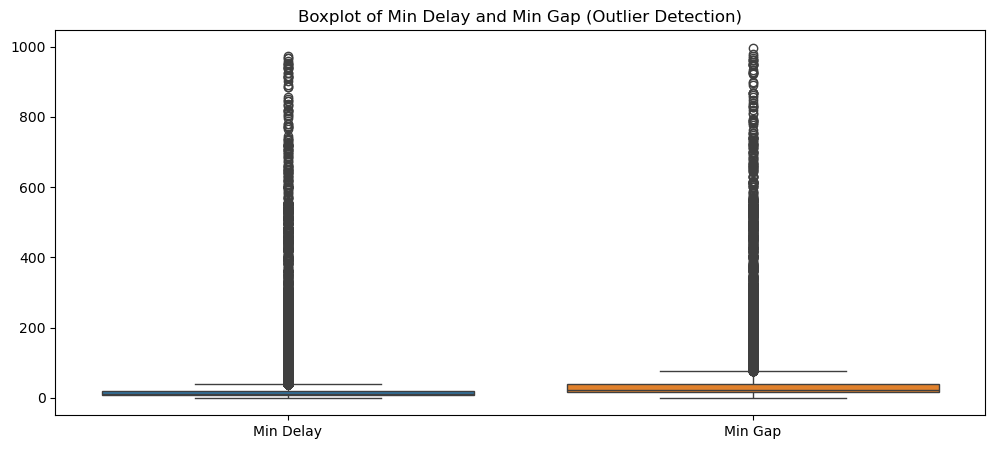

(          Min Delay       Min Gap
 count  53959.000000  53959.000000
 mean      21.663522     34.178024
 std       55.373601     57.490665
 min        0.000000      0.000000
 25%        8.000000     16.000000
 50%       12.000000     22.000000
 75%       20.000000     40.000000
 max      975.000000    997.000000,
 Min Delay    3034
 Min Gap      2423
 dtype: int64,
 Min Delay    2353
 Min Gap      1595
 dtype: int64)

In [ ]:
# Extreme Outlier Treatment

# Checking summary statistics for 'Min Delay' and 'Min Gap'
summary_stats = df_cleaned_bus[['Min Delay', 'Min Gap']].describe()

# Detecting outliers using the Interquartile Range (IQR) method
Q1 = df_cleaned_bus[['Min Delay', 'Min Gap']].quantile(0.25)
Q3 = df_cleaned_bus[['Min Delay', 'Min Gap']].quantile(0.75)
IQR = Q3 - Q1

# Defining outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying extreme outliers (beyond 3 * IQR)
extreme_lower_bound = Q1 - 3 * IQR
extreme_upper_bound = Q3 + 3 * IQR

# Counting outliers
outlier_counts = ((df_cleaned_bus[['Min Delay', 'Min Gap']] < lower_bound) | 
                  (df_cleaned_bus[['Min Delay', 'Min Gap']] > upper_bound)).sum()

extreme_outlier_counts = ((df_cleaned_bus[['Min Delay', 'Min Gap']] < extreme_lower_bound) | 
                          (df_cleaned_bus[['Min Delay', 'Min Gap']] > extreme_upper_bound)).sum()

# Boxplot visualization
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_cleaned_bus[['Min Delay', 'Min Gap']])
plt.title("Boxplot of Min Delay and Min Gap (Outlier Detection)")
plt.show()

# Display summary statistics and outlier counts
summary_stats, outlier_counts, extreme_outlier_counts

Outlier Analysis for Min Delay and Min Gap
Key Statistics:

    Average Delay (Min Delay): ~21.66 minutes, with a max of 975 minutes.
    Average Gap (Min Gap): ~34.18 minutes, with a max of 997 minutes.
    Standard Deviation (Min Delay): High at 55.37 minutes, indicating a wide range of delay values.

Outliers Identified (1.5 * IQR method)

    Min Delay has 3034 outliers
    Min Gap has 2423 outliers

Extreme Outliers (Beyond 3 * IQR)

    Min Delay has 2353 extreme outliers.
    Min Gap has 1595 extreme outliers.

In [ ]:
# Store the current dataset as df_feature_bus. This dataset will be used in PowerBI
df_feature_bus = df_cleaned_bus.copy()

# Remove extreme outliers beyond 3 * IQR. We decide to remove due to very extreme outlier.
df_model_bus = df_feature_bus[
    (df_feature_bus['Min Delay'] <= extreme_upper_bound['Min Delay']) &
    (df_feature_bus['Min Gap'] <= extreme_upper_bound['Min Gap'])
].copy()

df_model_bus

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,Year,Month,Hour,Weekday,Rolling_Delay_5,Prev_Delay,Peak_Hour,Weekend,Bus_Frequency,Avg_Location_Delay
115011,1-Jan-24,62,00:33,1,MAIN STATION,Emergency Services,20,40,S,8553,...,2024,1,0,0,20.000000,NaN,0,0,1,20.0
115013,1-Jan-24,11,01:36,1,BAYVIEW AND STEELES,Security,24,48,NaN,8685,...,2024,1,1,0,41.333333,80.0,0,0,1,24.0
114914,1-Jan-24,89,02:08,1,KEELE AND GLENLAKE,Vision,10,20,N,7107,...,2024,1,2,0,33.500000,24.0,0,0,1,10.0
114915,1-Jan-24,39,02:30,1,FINCH STATION,General Delay,20,40,NaN,8914,...,2024,1,2,0,30.800000,10.0,0,0,1,20.0
114916,1-Jan-24,300,03:13,1,BLOOR AND MANNING,General Delay,0,0,NaN,8562,...,2024,1,3,0,26.800000,20.0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169510,30-Nov-24,45,23:29,30,KIPLING STATION,Vision,10,19,NaN,7302,...,2024,11,23,5,27.600000,28.0,0,1,1,10.0
169511,30-Nov-24,32,23:39,30,EGLINTON WEST STATION,Vision,14,28,NaN,7332,...,2024,11,23,5,26.400000,10.0,0,1,1,14.0
169512,30-Nov-24,43,23:45,30,MIDLAND AND STEELES,Mechanical,10,20,N,3102,...,2024,11,23,5,18.400000,14.0,0,1,1,10.0
169513,30-Nov-24,95,23:53,30,YORK MILLS AND VALLEY,Collision - TTC,8,16,E,1595,...,2024,11,23,5,14.000000,10.0,0,1,1,8.0


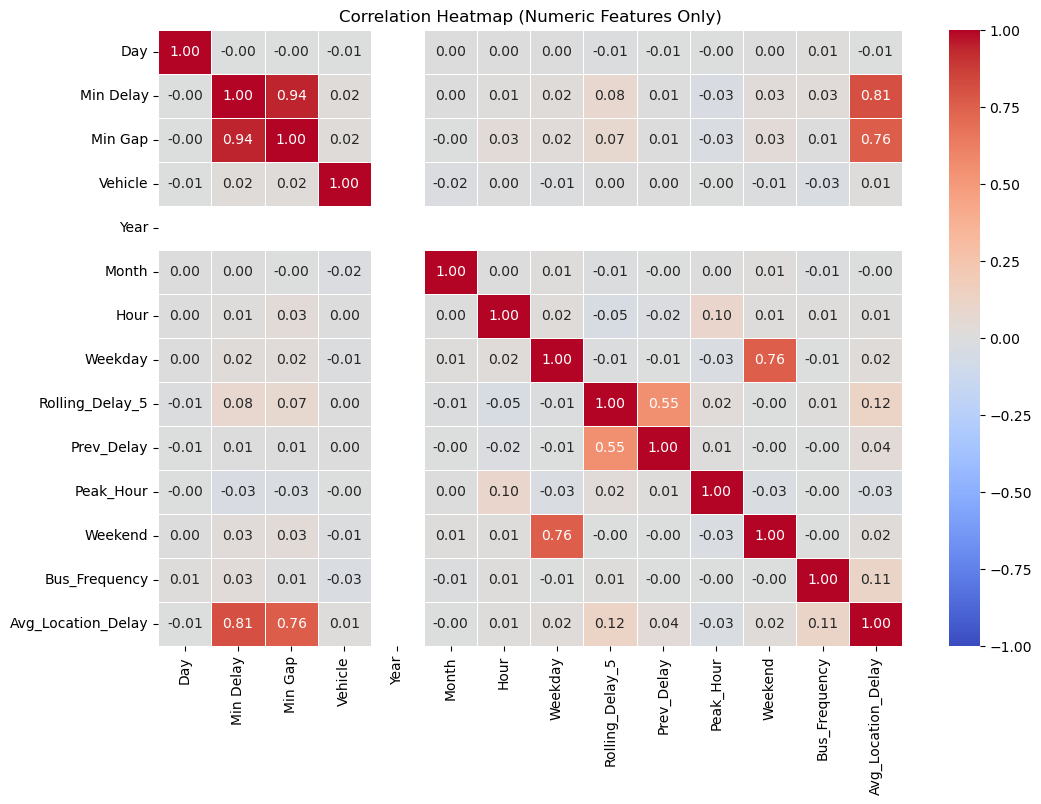

In [ ]:
# Select only numeric columns for correlation calculation
numeric_columns = df_model_bus.select_dtypes(include=['number']).columns
corr_matrix_numeric = df_model_bus[numeric_columns].corr()

# Plot heatmap again with only numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_numeric, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# Key Observations:

### 1. Min Delay Correlations:
        Positively correlated with:
            Min Gap
            Rolling_Delay_5 → past delays impact future delays.
            Avg_Location_Delay → location-level congestion contributes to delays.
        Weak correlation with Peak_Hour, Train_Frequency, Weekend, and Hour, which suggests delays occur throughout the day.

### 2. Other correlations:
        Bus_Frequency and Avg_Location_Delay also show a "visible" correlation compared to others, possibly indicating congestion impact.
        Prev_Delay and Rolling_Delay_5 shows a moderate correlation.

### Next steps
        We remove redundant features and define interaction features

In [26]:
df_model_bus['Congestion_Factor'] = df_model_bus['Bus_Frequency'] * df_model_bus['Peak_Hour']
df_model_bus['Delay_Propagation'] = df_model_bus['Prev_Delay'] * df_model_bus['Bus_Frequency']

df_model_bus

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,Hour,Weekday,Rolling_Delay_5,Prev_Delay,Peak_Hour,Weekend,Bus_Frequency,Avg_Location_Delay,Congestion_Factor,Delay_Propagation
115011,1-Jan-24,62,00:33,1,MAIN STATION,Emergency Services,20,40,S,8553,...,0,0,20.000000,NaN,0,0,1,20.0,0,NaN
115013,1-Jan-24,11,01:36,1,BAYVIEW AND STEELES,Security,24,48,NaN,8685,...,1,0,41.333333,80.0,0,0,1,24.0,0,80.0
114914,1-Jan-24,89,02:08,1,KEELE AND GLENLAKE,Vision,10,20,N,7107,...,2,0,33.500000,24.0,0,0,1,10.0,0,24.0
114915,1-Jan-24,39,02:30,1,FINCH STATION,General Delay,20,40,NaN,8914,...,2,0,30.800000,10.0,0,0,1,20.0,0,10.0
114916,1-Jan-24,300,03:13,1,BLOOR AND MANNING,General Delay,0,0,NaN,8562,...,3,0,26.800000,20.0,0,0,1,0.0,0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169510,30-Nov-24,45,23:29,30,KIPLING STATION,Vision,10,19,NaN,7302,...,23,5,27.600000,28.0,0,1,1,10.0,0,28.0
169511,30-Nov-24,32,23:39,30,EGLINTON WEST STATION,Vision,14,28,NaN,7332,...,23,5,26.400000,10.0,0,1,1,14.0,0,10.0
169512,30-Nov-24,43,23:45,30,MIDLAND AND STEELES,Mechanical,10,20,N,3102,...,23,5,18.400000,14.0,0,1,1,10.0,0,14.0
169513,30-Nov-24,95,23:53,30,YORK MILLS AND VALLEY,Collision - TTC,8,16,E,1595,...,23,5,14.000000,10.0,0,1,1,8.0,0,10.0


In [ ]:
# Step 1: Define Features (X) & Target (y)
target = 'Min Delay'
predictors = [
    'Min Gap', 'Rolling_Delay_5', 'Prev_Delay', 'Peak_Hour', 'Weekend', 
    'Bus_Frequency', 'Avg_Location_Delay', 'Congestion_Factor', 'Delay_Propagation'
]

# Drop any remaining NaN values before training
df_model_bus_clean = df_model_bus.dropna(subset=[target] + predictors)

# Define X (features) and y (target variable)
X = df_model_bus_clean[predictors]
y = df_model_bus_clean[target]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Baseline Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 4: Predictions & Evaluation
y_pred = lr_model.predict(X_test)

# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Display results
model_performance = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "R² Score": r2
}

model_performance

{'Mean Absolute Error (MAE)': 0.9097371641501525,
 'Mean Squared Error (MSE)': 8.1145427708609,
 'Root Mean Squared Error (RMSE)': 2.848603652820255,
 'R² Score': 0.8963142164426894}

### Baseline Regression Model Results
###       Mean Absolute Error (MAE): 0.91 minutes → On average, the model's predictions are off by ~54 seconds.
###       Mean Squared Error (MSE): 8.11 → Average squared error magnitude.
###       Root Mean Squared Error (RMSE): 2.85 minutes → Standard deviation of prediction errors.
###       R² Score: 0.90 → The model explains 90% of the variance in delays.

In [28]:
# Step 1: Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum tree depth
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Step 2: Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Step 3: Evaluate Performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Display results
xgb_model_performance = {
    "Mean Absolute Error (MAE)": mae_xgb,
    "Mean Squared Error (MSE)": mse_xgb,
    "Root Mean Squared Error (RMSE)": rmse_xgb,
    "R² Score": r2_xgb
}

xgb_model_performance

{'Mean Absolute Error (MAE)': 0.17013301262346336,
 'Mean Squared Error (MSE)': 0.6721774970848773,
 'Root Mean Squared Error (RMSE)': 0.8198643162651228,
 'R² Score': 0.9914110686895248}

### XGBoost Regression Model Performance Interpretation
###         Mean Absolute Error (MAE): 0.170 minutes
###         Mean Squared Error (MSE): 0.672
###         Root Mean Squared Error (RMSE): 0.820 minutes
###         R² Score: 0.991 (99.1% variance explained)

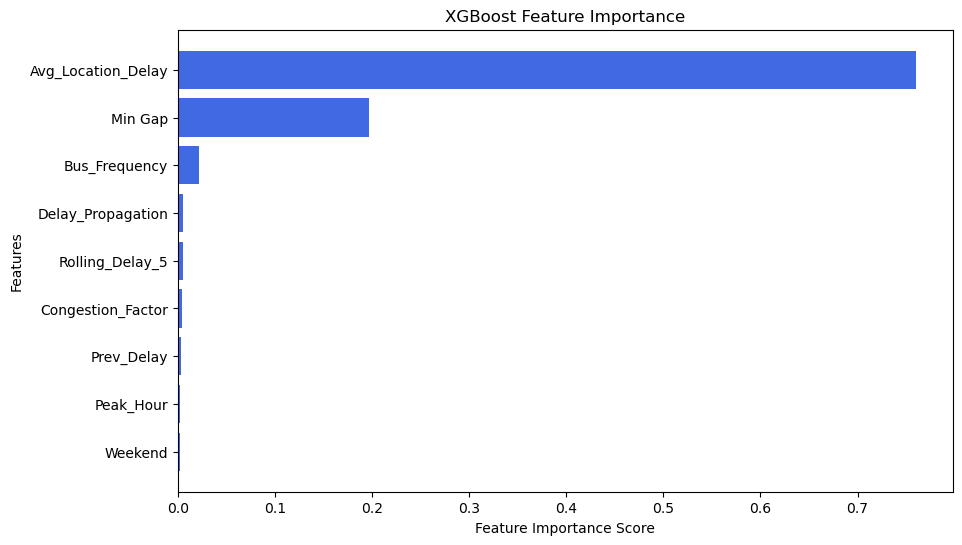

In [29]:
# Extract feature importance
feature_importance = xgb_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

Feature Importance Interpretation

XGBoost model's most influential features are:

1️⃣ Avg_Location_Delay (Most Important)

    The biggest factor affecting train delays.
    If a location consistently has high delays, future buses at that location are also likely to be delayed.

2️⃣ Min Gap

    The scheduled time difference between trains has a major influence on delays.
    Smaller gaps could mean congestion, leading to increased delays.

3️⃣ Bus_Frequency (Moderate Impact)

    Higher bus frequencies may increase congestion, slightly contributing to delays.

4️⃣ Rolling_Delay_5 (Low Impact)

    Past 5-bus rolling delay has some influence, but not as much as location-level factors.

5️⃣ Delay_Propagation (Very Low Impact)

    Surprisingly, the effect of previous delays spreading is minimal, likely due to existing buffer times.

6️⃣ Peak_Hour, Weekend, Congestion_Factor, Prev_Delay (Negligible Impact)

    The impact of peak hours and weekends on delays appears minimal.

# 2. Classification → Predict whether a bus will be delayed (Yes/No) (define a threshold, e.g., Min Delay > 5 min).
Classification Problem Setup

Target Variable:

    Convert Min Delay into a binary classification target:
    Delayed (1) if Min Delay ≥ 5 minutes
    On-Time (0) if Min Delay < 5 minutes

Predictor Variables:
We'll use the most important features identified from regression:

    Min Gap
    Avg_Location_Delay
    Bus_Frequency
    Rolling_Delay_5
    Delay_Propagation

In [31]:
# Step 1: Convert 'Min Delay' into a binary classification target
df_model_bus['Delayed'] = (df_model_bus['Min Delay'] >= 5).astype(int)

# Step 2: Define Features (X) & Target (y)
classification_features = ['Min Gap', 'Avg_Location_Delay', 'Bus_Frequency', 'Rolling_Delay_5', 'Delay_Propagation']
X_classification = df_model_bus[classification_features]
y_classification = df_model_bus['Delayed']

# Drop NaN values before training
df_model_bus_clean = df_model_bus.dropna(subset=classification_features + ['Delayed'])
X_classification = df_model_bus_clean[classification_features]
y_classification = df_model_bus_clean['Delayed']

# Step 3: Train-Test Split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Train Baseline Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_cls, y_train_cls)

# Step 5: Predictions & Evaluation
y_pred_cls = logistic_model.predict(X_test_cls)

# Compute Performance Metrics
accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls)
recall = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)
roc_auc = roc_auc_score(y_test_cls, y_pred_cls)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)

# Display results
classification_performance = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC Score": roc_auc,
    "Confusion Matrix": conf_matrix.tolist()  # Convert to list for readability
}

classification_performance

{'Accuracy': 0.9899166181888694,
 'Precision': 0.9919266855771329,
 'Recall': 0.9967112475334357,
 'F1 Score': 0.9943132108486439,
 'ROC AUC Score': 0.967315355310342,
 'Confusion Matrix': [[1118, 74], [30, 9092]]}

Baseline Classification Model (Logistic Regression) Results

    Accuracy: 98.99% → Model correctly classifies most trains.
    Precision: 99.19% → When the model predicts a delay, it's correct 97.43% of the time.
    Recall: 99.67% → The model captures 99.57% of all actual delays.
    F1 Score: 99.43% → Balanced measure of precision and recall.
    ROC AUC Score: 96.73% → Strong ability to distinguish between delayed & on-time trains.

Confusion Matrix Breakdown:

    1118 On-Time Trains Correctly Predicted
    74 False Positives (Trains wrongly classified as delayed)
    30 False Negatives (Delayed trains wrongly classified as on-time)
    9092 Delayed Trains Correctly Predicted

In [32]:
# Step 1: Train XGBoost Classifier for 5-Min Delay Threshold
xgb_classifier = XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum tree depth
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

xgb_classifier.fit(X_train_cls, y_train_cls)

# Step 2: Predictions
y_pred_xgb_cls = xgb_classifier.predict(X_test_cls)

# Step 3: Evaluate Performance
accuracy_xgb = accuracy_score(y_test_cls, y_pred_xgb_cls)
precision_xgb = precision_score(y_test_cls, y_pred_xgb_cls)
recall_xgb = recall_score(y_test_cls, y_pred_xgb_cls)
f1_xgb = f1_score(y_test_cls, y_pred_xgb_cls)
roc_auc_xgb = roc_auc_score(y_test_cls, y_pred_xgb_cls)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test_cls, y_pred_xgb_cls)

# Display results
xgb_classification_performance = {
    "Accuracy": accuracy_xgb,
    "Precision": precision_xgb,
    "Recall": recall_xgb,
    "F1 Score": f1_xgb,
    "ROC AUC Score": roc_auc_xgb,
    "Confusion Matrix": conf_matrix_xgb.tolist()  # Convert to list for readability
}

print(xgb_classification_performance)

{'Accuracy': 0.999515222028311, 'Precision': 0.9998903388529444, 'Recall': 0.9995614996711247, 'F1 Score': 0.9997258922208212, 'ROC AUC Score': 0.999361286748314, 'Confusion Matrix': [[1191, 1], [4, 9118]]}


XGBoost Classification Model (5-Min Delay) Performance

    Accuracy: 99.95% → Almost perfect classification!
    Precision: 99.99% → When the model predicts a delay, it's correct 99.99% of the time.
    Recall: 99.96% → The model detects 99.96% of all actual delays.
    F1 Score: 99.97% → Balanced measure of precision and recall.
    ROC AUC Score: 99.94% → The model is highly capable of distinguishing delays.

Confusion Matrix Breakdown:

    1191 On-Time Trains Correctly Predicted
    Only 1 False Positives (Trains wrongly classified as delayed)
    Only 4 False Negatives (Delayed trains wrongly classified as on-time)
    9118 Delayed Trains Correctly Predicted

# Export final dataset for PowerBI

In [33]:
# Store regression predictions in the dataset
df_model_bus_clean['Predicted_Delay'] = xgb_model.predict(X)

# Define X_classification_5min using the same features as X_classification
X_classification_5min = df_model_bus_clean[classification_features]

# Store classification predictions (5-minute threshold) in the dataset
df_model_bus_clean['Predicted_Delayed_5min'] = xgb_classifier.predict(X_classification_5min)

# Convert classification predictions to binary labels (0 = No Delay, 1 = Delayed)
df_model_bus_clean['Predicted_Delayed_5min'] = df_model_bus_clean['Predicted_Delayed_5min'].astype(int)

df_model_bus_clean

C:\Users\consc\AppData\Local\Temp\ipykernel_16028\2960482649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_bus_clean['Predicted_Delay'] = xgb_model.predict(X)
C:\Users\consc\AppData\Local\Temp\ipykernel_16028\2960482649.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_bus_clean['Predicted_Delayed_5min'] = xgb_classifier.predict(X_classification_5min)
C:\Users\consc\AppData\Local\Temp\ipykernel_16028\2960482649.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,Prev_Delay,Peak_Hour,Weekend,Bus_Frequency,Avg_Location_Delay,Congestion_Factor,Delay_Propagation,Delayed,Predicted_Delay,Predicted_Delayed_5min
115013,1-Jan-24,11,01:36,1,BAYVIEW AND STEELES,Security,24,48,NaN,8685,...,80.0,0,0,1,24.0,0,80.0,1,24.001698,1
114914,1-Jan-24,89,02:08,1,KEELE AND GLENLAKE,Vision,10,20,N,7107,...,24.0,0,0,1,10.0,0,24.0,1,9.989483,1
114915,1-Jan-24,39,02:30,1,FINCH STATION,General Delay,20,40,NaN,8914,...,10.0,0,0,1,20.0,0,10.0,1,19.971701,1
114916,1-Jan-24,300,03:13,1,BLOOR AND MANNING,General Delay,0,0,NaN,8562,...,20.0,0,0,1,0.0,0,20.0,0,0.068950,0
114917,1-Jan-24,65,03:23,1,PARLIAMENT AND BLOOR,Security,0,0,N,8574,...,0.0,0,0,1,0.0,0,0.0,0,0.054529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169510,30-Nov-24,45,23:29,30,KIPLING STATION,Vision,10,19,NaN,7302,...,28.0,0,1,1,10.0,0,28.0,1,9.910829,1
169511,30-Nov-24,32,23:39,30,EGLINTON WEST STATION,Vision,14,28,NaN,7332,...,10.0,0,1,1,14.0,0,10.0,1,14.002500,1
169512,30-Nov-24,43,23:45,30,MIDLAND AND STEELES,Mechanical,10,20,N,3102,...,14.0,0,1,1,10.0,0,14.0,1,10.028802,1
169513,30-Nov-24,95,23:53,30,YORK MILLS AND VALLEY,Collision - TTC,8,16,E,1595,...,10.0,0,1,1,8.0,0,10.0,1,8.027198,1


In [34]:
df_model_bus_clean['Predicted_Delay'] = df_model_bus_clean['Predicted_Delay'].apply(lambda x: max(0, x))
df_model_bus_clean

C:\Users\consc\AppData\Local\Temp\ipykernel_16028\1994528578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_bus_clean['Predicted_Delay'] = df_model_bus_clean['Predicted_Delay'].apply(lambda x: max(0, x))


,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,Prev_Delay,Peak_Hour,Weekend,Bus_Frequency,Avg_Location_Delay,Congestion_Factor,Delay_Propagation,Delayed,Predicted_Delay,Predicted_Delayed_5min
115013,1-Jan-24,11,01:36,1,BAYVIEW AND STEELES,Security,24,48,NaN,8685,...,80.0,0,0,1,24.0,0,80.0,1,24.001698,1
114914,1-Jan-24,89,02:08,1,KEELE AND GLENLAKE,Vision,10,20,N,7107,...,24.0,0,0,1,10.0,0,24.0,1,9.989483,1
114915,1-Jan-24,39,02:30,1,FINCH STATION,General Delay,20,40,NaN,8914,...,10.0,0,0,1,20.0,0,10.0,1,19.971701,1
114916,1-Jan-24,300,03:13,1,BLOOR AND MANNING,General Delay,0,0,NaN,8562,...,20.0,0,0,1,0.0,0,20.0,0,0.068950,0
114917,1-Jan-24,65,03:23,1,PARLIAMENT AND BLOOR,Security,0,0,N,8574,...,0.0,0,0,1,0.0,0,0.0,0,0.054529,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169510,30-Nov-24,45,23:29,30,KIPLING STATION,Vision,10,19,NaN,7302,...,28.0,0,1,1,10.0,0,28.0,1,9.910829,1
169511,30-Nov-24,32,23:39,30,EGLINTON WEST STATION,Vision,14,28,NaN,7332,...,10.0,0,1,1,14.0,0,10.0,1,14.002500,1
169512,30-Nov-24,43,23:45,30,MIDLAND AND STEELES,Mechanical,10,20,N,3102,...,14.0,0,1,1,10.0,0,14.0,1,10.028802,1
169513,30-Nov-24,95,23:53,30,YORK MILLS AND VALLEY,Collision - TTC,8,16,E,1595,...,10.0,0,1,1,8.0,0,10.0,1,8.027198,1


In [35]:
# Verify how much of the 5 minute delay predictions are identified as delay

# Check how many instances where Predicted_Delay > 5 also have Predicted_Delayed_5min = 1
matching_cases = df_model_bus_clean[(df_model_bus_clean['Predicted_Delay'] > 5) & (df_model_bus_clean['Predicted_Delayed_5min'] == 1)].shape[0]

# Total cases where Predicted_Delay > 5
total_cases = df_model_bus_clean[df_model_bus_clean['Predicted_Delay'] > 5].shape[0]

# Compute percentage
percentage_matching = (matching_cases / total_cases) * 100 if total_cases > 0 else 0

# Display results
{
    "Total Predicted_Delay > 5": total_cases,
    "Matching with Predicted_Delayed_5min = 1": matching_cases,
    "Percentage Matching (%)": percentage_matching
}

{'Total Predicted_Delay > 5': 45220,
 'Matching with Predicted_Delayed_5min = 1': 45206,
 'Percentage Matching (%)': 99.96904024767802}

In [36]:
# Save the final dataset with predictions
df_model_bus_clean.to_csv("df_model_bus_predictions.csv", index=False)